# PeriodicityDetector QuickStart
-----------------------------------

##### In this notebook we will demonstrate initializing an Observations class - a time resolves observation series - and the PeriodicityDetector class to detect periodicity in the series.

### 1 Using the PeriodicityDetector class to run PDC on simulated velocity times series

`Observations` class enables one to load observation data from a given folder 
and place it into a TimeSeries object, or to load an existing time series. 
In this case we will choose the latter. 

In [1]:
from sparta import Observations
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template

In the example below we simulate a sinusoidal wave velocity time series and store it in a time series object.

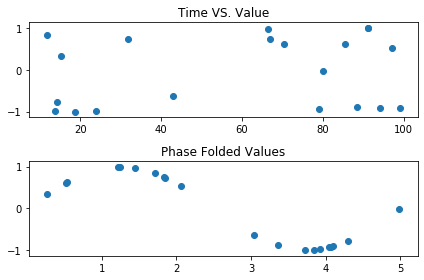

In [1]:
import random
import numpy as np
from sparta.Auxil.TimeSeries import TimeSeries

period = 5
size = 20

times = [(random.random() * 100) for _ in range(size)]
vals = [np.sin(t * 2 * np.pi / period) for t in times]

time_series = TimeSeries(size=size, times=times, vals=vals, period=period)

time_series.plot_velocities()

<br />
At this point we can use the Observation class to match a PeriodicityDetector to the time series:
<br />

In [4]:
obs = Observations(time_series=time_series)

obs.initialize_periodicity_detector(periodogram_grid_resolution=100, freq_range=(0.01, 1))

<br />
Now using the PeriodicityDetector to detect periodicity in the data using the GLS and PDC method is posible:
<br />

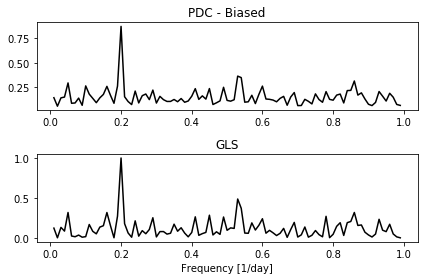

In [5]:
obs.periodicity_detector.run_PDC_process()

obs.periodicity_detector.run_GLS_process()

obs.periodicity_detector.periodogram_plots()


### 2. Using the PeriodicityDetector class to run USuRPer on simulated spectra

In the following code segment we simulate a single-line stereoscopic binary system (SB1) and using sparta classes to detect 
periodicity in the data using USuRPer.

First we initiate a Template object containing Phoenix library synthetic spectra.

In [8]:
# Assigning sun-like stellar parameters to the simulated spectra
temp = 4900
log_g = 4.5
metal = 0
alpha = 0

# Choosing wavelength range (Angstrom units)
min_val = 4900
max_val = 5100

# Loading a Phoenix synthetic spectrum
template = Template(temp=temp, log_g=log_g, metal=metal, alpha=alpha, min_val=min_val, max_val=max_val)

At this point, we use the template to simulate a single-line stereoscopic binary system (SB1) by generating 25 visits over 100 days,
and shifting them in sinusoidal wave velocities.
We represent the series in a TimeSeries object, then assigning it to an Observations object.

In [14]:
p = 5 # Assigning a five-day long period to the system.
half_amp = 100 # Assigning a 100 km/s magnitude to the velocity half amplitude change
N = 25 # Setting the number of observations to be 25

times = [(random.random() * 100) for _ in range(N)]
vals = [half_amp * np.sin(2 * t * np.pi / p) for t in times]
visit_spec_list = []

for i, v in enumerate(vals):
    new_wl = template.doppler(v)

    new_temp = Spectrum(wv=new_wl, sp=template.add_noise(-1)).SpecPreProccess()
    visit_spec_list.append(new_temp)

ts = TimeSeries(size=N, times=times, vals=visit_spec_list,
                       calculated_vrad_list=[])
obs = Observations(time_series=ts)

print("Simulated SB1 TimeSeries is ready and assigned to an Observations object")

Simulated SB1 TimeSeries is ready and assigned to an Observations object


Now we can run USURPER to detect periodicity in the observations, and print out the resulted periodogram.

Starting USuRPER... 


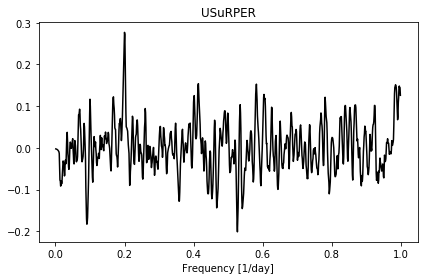

In [15]:
obs.initialize_periodicity_detector(freq_range=(1/1000, 1), periodogram_grid_resolution=1000)
print("Starting USuRPER... ")
obs.periodicity_detector.run_USURPER_process(calc_biased_flag=False, calc_unbiased_flag=True)
obs.periodicity_detector.periodogram_plots()